In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]
Version info.
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


# Prepare DataSet

In [3]:
%%script False
from sklearn.datasets import fetch_20newsgroups
mydata  = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
print('Training data size:', len(mydata['data']))

Couldn't find program: 'False'


In [4]:
%%script False
a = [np.unique(['.'.join(i.split('.')[:k]) for i in mydata.target_names]) for k in range(1,4)]
targets = np.unique(mydata.target)
mapping = dict(zip(targets, a[2]))

Couldn't find program: 'False'


In [5]:
import pickle
def save_mapping(mapping_dict, name):
    with open('data/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(mapping_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_mapping(name):
    with open('data/{}.pickle'.format(name), 'rb') as handle:
        return pickle.load(handle)

In [6]:
%%script False

def generate_new_clusters(obj):
    for v in mapping.values():
        for i in obj:
            if v.startswith(i):
                yield i

mapping2 = dict(zip(targets, generate_new_clusters(a[1])))
mapping3 = dict(zip(targets, generate_new_clusters(a[0])))
print(mapping2)
print(mapping3)
print(len(mapping))
print(len(mapping2))
print(len(mapping3))

Couldn't find program: 'False'


In [7]:
TARGET_COLUMNS = ['clusters', 'clusters_2', 'clusters_3']
TEXT_COLUMN = 'data'

In [8]:
%%script False

df = pd.DataFrame({'data': mydata.data, 'target': mydata.target})
for mapping, col in zip([mapping, mapping2, mapping3], TARGET_COLUMNS):
    df[col] = df['target'].apply(lambda x: mapping[x])
    
df.to_parquet('data/df.parquet')

Couldn't find program: 'False'


# Preproccessing DataSet

In [9]:
%%script False
df = pd.read_parquet('data/df.parquet')

Couldn't find program: 'False'


In [10]:
def drop_duplicate_values(x):
    return x.drop_duplicates().reset_index(drop=True)

# Clusters Frequency

In [11]:
def get_frequency(column_name):
    targets, frequency = np.unique(df[column_name], return_counts=True)
    if column_name == 'clusters_3':
        return targets, frequency
    return range(len(targets)), frequency

def plot_clusters(func, title, type='bar'):
    fig, axs = plt.subplots(1, 3, figsize=(19, 3), sharey=False)
    for num, col in enumerate(TARGET_COLUMNS):
        if type == 'bar':
            axs[num].bar(*func(col))
        else:
            axs[num].scatter(**func(col))
    fig.suptitle(title)

In [12]:
%%script False
plot_clusters(get_frequency, 'Clusters Frequency')

Couldn't find program: 'False'


In [13]:
%%script False
from sklearn.preprocessing import LabelEncoder
for col in TARGET_COLUMNS:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])    
    save_mapping(dict(enumerate(le.classes_)), col)
df = df.drop(columns=['target'])

Couldn't find program: 'False'


In [14]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader_analyzer = SentimentIntensityAnalyzer()

def word_lemmatizer(word):
    word = word.replace('_', '')
    word1 = wordnet_lemmatizer.lemmatize(word, pos = "n") # NOUNS
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # VERB
    return wordnet_lemmatizer.lemmatize(word2, pos = ("a")) # ADJ
    

def text_lemmatizer(text):
    return ' '.join(map(word_lemmatizer, text))


def lemmatizer(x):
    x[TEXT_COLUMN] = x[TEXT_COLUMN].apply(lambda text: text_lemmatizer(tokenize(remove_stopwords(text))))
    return x

def get_sentimnent(x):
    x['sentimnent'] = x[TEXT_COLUMN].apply(lambda text: vader_analyzer.polarity_scores(text))
    return x

[nltk_data] Downloading package wordnet to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/dlab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
def text_feature_selector(x):
    x['word_count'] = x[TEXT_COLUMN].apply(lambda text : len(str(text).split()))
    x['length'] = x[TEXT_COLUMN].apply(len)
    x['word_density'] = x['length'] / x['word_count']
    return x

In [16]:
%%script False
display(df.shape)
df = FunctionTransformer(drop_duplicate_values, validate=False).transform(df)
display(df.shape)
df = FunctionTransformer(lemmatizer, validate=False).transform(df)
display(df.shape)
df = FunctionTransformer(text_feature_selector, validate=False).transform(df)
display(df.shape)
df = FunctionTransformer(get_sentimnent, validate=False).transform(df)
display(df.shape)
df = pd.concat([df, pd.io.json.json_normalize(df['sentimnent'])], axis=1).drop(columns=['sentimnent'])
display(df.shape)

df.to_parquet('data/preprocessed_df.parquet')

Couldn't find program: 'False'


In [17]:
df = pd.read_parquet('data/preprocessed_df.parquet')

In [18]:
df.shape

(18371, 11)

In [19]:
from functools import partial
def get_word_density(colname, feature):
    tdf = df.groupby([colname]).agg(feature).mean()
    return tdf.index, tdf.values

In [20]:
# plot_clusters(partial(get_word_density, feature='word_density') , 'Clusters word_density')

In [21]:
# plot_clusters(partial(get_word_density, feature='length'), 'Clusters length')

In [22]:
# plot_clusters(partial(get_word_density, feature='word_count'), 'Clusters word_count')

In [23]:
from wordcloud import WordCloud

def clusters_wordcloud(name):
    mapping = load_mapping(name)
    pdf = pd.DataFrame(df.groupby(name).agg('data').sum())

    fig = plt.figure(figsize=(20, 25))
    for i in range(len(mapping)):
        ax = fig.add_subplot(7,3,i+1)
        wordcloud = WordCloud().generate(pdf['data'][i])
        ax.set_title("WordCloud " + mapping[pdf.index[i]])
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

In [24]:
# clusters_wordcloud('clusters')

In [25]:
# clusters_wordcloud('clusters_2')

In [26]:
# clusters_wordcloud('clusters_3')

In [27]:
df.head()

,data,clusters,clusters_2,clusters_3,word_count,length,word_density,compound,neg,neu,pos
0,I sure bashers Pens fan pretty confuse lack ki...,10,8,3,71,400,5.633803,0.5719,0.244,0.466,0.290
1,My brother market high performance video card ...,3,3,1,39,232,5.948718,0.8225,0.029,0.752,0.219
2,Finally say dream about Mediterranean That new...,17,14,6,161,926,5.751553,-0.9970,0.366,0.555,0.079
3,Think It s SCSI card DMA transfer NOT disk The...,3,3,1,82,476,5.804878,0.9153,0.000,0.822,0.178
4,I old Jasmine drive I use new system My unders...,4,3,1,58,342,5.896552,0.5574,0.000,0.911,0.089


# TF-iDF

In [28]:
text_data = df[TEXT_COLUMN].tolist()
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(text_data)

In [29]:
vectors

<18371x86821 sparse matrix of type '<class 'numpy.float64'>'
	with 1208503 stored elements in Compressed Sparse Row format>

In [30]:
def reduced_results(col, results):
    results_pd = pd.concat([df[[col]], pd.DataFrame(data=results, index=df.index, columns=["x", "y"])], axis=1)
    results_pd = results_pd[results_pd['x'] < 60]
    return {
        'x': results_pd['x'].values,
        'y': results_pd['y'].values,
        'c': results_pd[col].values
    }

def plot_clusters_svd(vectors):
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    plot_clusters(partial(reduced_results, results=svd.fit_transform(vectors)), 'scatter plot for clusters SVD', type='lld')

def plot_clusters_two_decompositions(vectors, with_text_features=True, n_components=300):
    svd = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
    features = svd.fit_transform(vectors)

    res = features
    if with_text_features:
        tmp = df[['word_count', 'length', 'word_density', 'compound', 'neg', 'neu', 'pos']]
        tmp = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(tmp)
        tmp = StandardScaler().fit_transform(tmp)
        res = np.concatenate([np.array(tmp),features], axis=1)
    pca = PCA(n_components=2, random_state=42)
    features2 = pca.fit_transform(res)
    plot_clusters(partial(reduced_results, results=features2), 'scatter plot for clusters SVD & then PCA', type='lld')

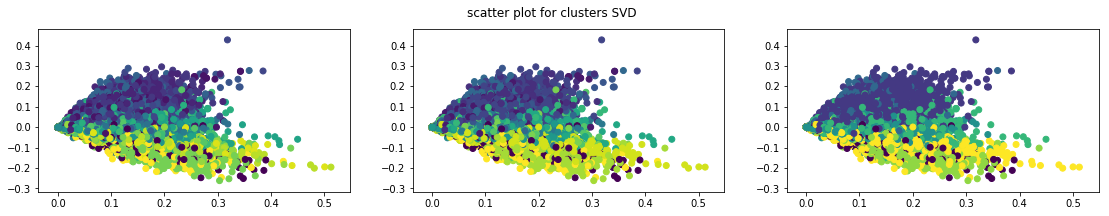

In [31]:
plot_clusters_svd(vectors)

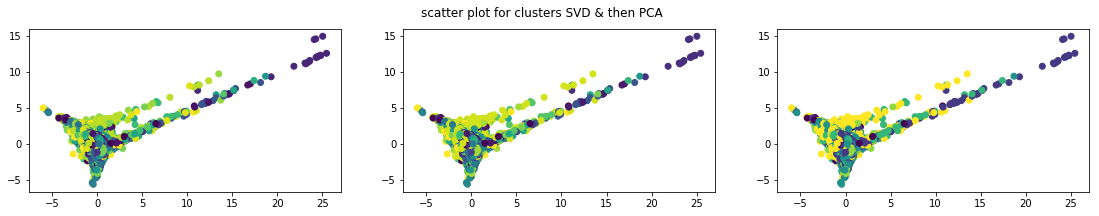

In [32]:
plot_clusters_two_decompositions(vectors)

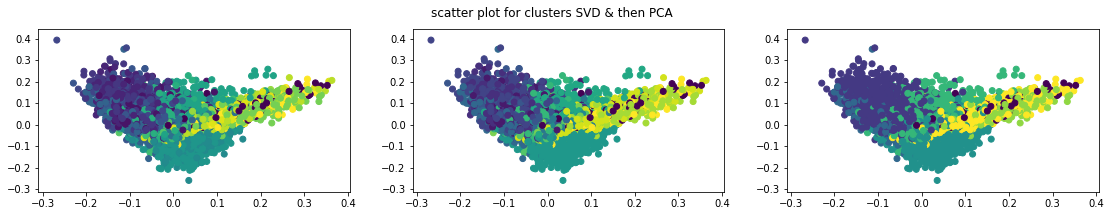

In [34]:
plot_clusters_two_decompositions(vectors, with_text_features=False, n_components=15)

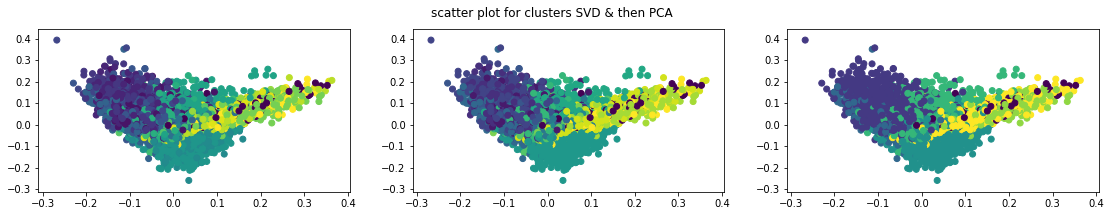

In [35]:
plot_clusters_two_decompositions(vectors, with_text_features=False, n_components=300)

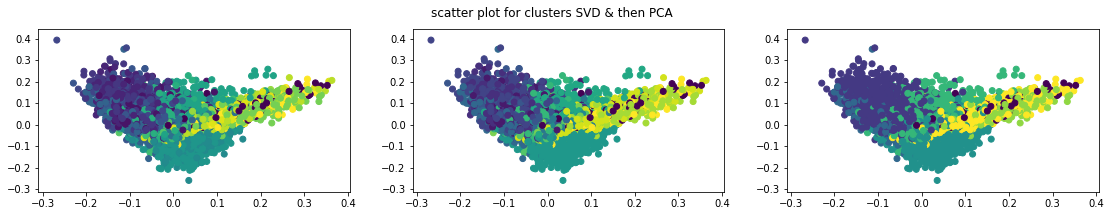

In [36]:
plot_clusters_two_decompositions(vectors, with_text_features=False, n_components=1000)